In [1]:
MODEL_VERSION = "02"
NUM_TIMESTEPS = 28
RUN_ON_SAMPLE = False
SAMPLE_SIZE = 500
SCALING = False

DROPOUT = 0.3
MIN_LR = 1e-4
MAX_LR = 1e-2
STEP_SIZE = 2
BATCH_SIZE = 10*1024
PREDICT_BATCH_SIZE = 20*1024
NUM_EPOCHS = [4, 28, 4]

In [2]:
import os, sys, datetime, pickle, gc
from time import time, ctime
from pprint import pprint
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Lambda
from tensorflow.keras.backend import repeat_elements
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
seeded_value = 88888
pd.set_option('display.max_colwidth', 50)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
# suppress scientific notation
pd.options.display.precision = 2
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
print([
    tf.__version__
])

['2.2.0']


In [7]:
start_time = time()
start = datetime.now()
print(ctime(start_time))

Thu Jun 25 19:17:18 2020


### Files
1. calendar.csv - Contains information about the dates on which the products are sold.
2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
4. sell_prices.csv - Contains information about the price of the products sold per store and date.
5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [8]:
DATA_DIR = "../data/"
RESULTS_DIR = "../results/"
PICKLE_DIR = "../data/preprocessed/"

In [9]:
CARDINAL_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id']

In [10]:
TRAIN_INDICES = np.arange(1, 1885 + 1) # Could use 1156 i.e. only 2 years of data
VALID_INDICES = np.arange(1886, 1913 + 1)
PUBLIC_INDICES = np.arange(1914, 1941 + 1)
PRIVATE_INDICES = np.arange(1942, 1969 + 1)

In [11]:
print(min(TRAIN_INDICES), max(TRAIN_INDICES), len(TRAIN_INDICES))
print(min(VALID_INDICES), max(VALID_INDICES), len(VALID_INDICES))
print(min(PUBLIC_INDICES), max(PUBLIC_INDICES), len(PUBLIC_INDICES))
print(min(PRIVATE_INDICES), max(PRIVATE_INDICES), len(PRIVATE_INDICES))

1 1885 1885
1886 1913 28
1914 1941 28
1942 1969 28


Read about memory management in pandas [here](https://pythonspeed.com/articles/pandas-load-less-data/)

In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
def read_data(infer_mode:bool=False):
    print('Reading files...')
    
    calendar = pd.read_csv('../data/calendar.csv').fillna("None")
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('../data/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    sales = pd.read_csv('../data/sales_train_evaluation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    sales[['d_'+str(i) for i in PRIVATE_INDICES]] = pd.DataFrame(np.zeros(shape=(sales.shape[0], len(PRIVATE_INDICES))))
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    
    submission = pd.read_csv('../data/sample_submission.csv')
    
    pprint({
        "calendar.shape" : calendar.shape,
        "sell_prices.shape" : sell_prices.shape,
        "sales.shape" : sales.shape,
        "submission.shape" : submission.shape
    })
    
    return calendar, sell_prices, sales, submission

In [14]:
def add_dateparts(calendar, datecolname):
    calendar["Date"] = pd.to_datetime(calendar[datecolname], format = ("%Y-%m-%d"))
    calendar["Year"] = calendar["Date"].dt.year.astype('int16')
    calendar["Quarter"] = calendar["Date"].dt.quarter
    calendar["Month"] = calendar["Date"].dt.month
    calendar["Week"] = calendar["Date"].dt.week
    calendar["Day"] = calendar["Date"].dt.day
    calendar["DOW"] = calendar["Date"].dt.dayofweek
    calendar = reduce_mem_usage(calendar)
    return calendar

In [15]:
def melt_join_fill(sales, calendar, sell_prices):
    if RUN_ON_SAMPLE:
        sales = pd.melt(sales.sample(SAMPLE_SIZE),
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    else:
        sales = pd.melt(sales,
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    print("[INFO] ", "Melting  -- COMPLETE", ctime(time()))

    
    gc.collect()
    
    sales = pd.merge(sales, calendar, how="left", left_on="day_id", right_on="d")
    print("[INFO] ", "Merging1 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    sales = pd.merge(sales, sell_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
    print("[INFO] ", "Merging2 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    # if sell_price is NA
    sales = sales.sort_values(by=CARDINAL_VARS+["date"])
    
    gc.collect()
    
    sales["sell_price_available"] = np.where(sales.sell_price.isna(), "N", "Y")
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].ffill()
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].bfill()
    sales = sales.drop(["d", "wday", 'date', 'wm_yr_wk', 'weekday', 'month', 'year'], axis=1)
    
    sales['day_id'] = sales['day_id'].astype(str).apply(lambda x: x[2:]).astype(np.int16)
    
    print("[INFO] ", "Imputing -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    sales['weights'] = sales["sell_price"] * sales["demand"]
    sales['rolling_weights'] = sales.groupby(CARDINAL_VARS)['weights'].rolling(window=NUM_TIMESTEPS, min_periods=1).sum().reset_index(drop=True)
    
    sales['weights'] = sales['weights'].apply(lambda x: np.max((1.0, x)))
    sales['rolling_weights'] = sales['rolling_weights'].apply(lambda x: np.max((1.0, x)))
    
    print("[INFO] ", "Weighting -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    print("[INFO] ", "Final dataset contains", sales.shape)
    
    return sales.reset_index(drop=True)

In [16]:
if not os.path.exists(PICKLE_DIR+"merged_df.pickle"):
    
    calendar, sell_prices, sales, submission = read_data()
    
    calendar = add_dateparts(calendar, "date")
    
    Y_VARS = sales.columns[sales.columns.str.startswith("d_")]

    data = melt_join_fill(sales, calendar, sell_prices)
    
    del sales, calendar, sell_prices
    gc.collect()

    print("Saving all data to ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR, "merged_df.pickle"),"wb") as f:
        pickle.dump((data), f)
else:
    print("Pickle exists hence loading from pickle file ---> ", PICKLE_DIR)
    with open(os.path.join(PICKLE_DIR+"merged_df.pickle"), "rb") as f:
        data = pickle.load(f)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1947 columns
{'calendar.shape': (1969, 14),
 'sales.shape': (30490, 1975),
 'sell_prices.shape': (6841121, 4),
 'submission.shape': (60980, 29)}
Mem. usage decreased to  0.15 Mb (30.4% reduction)
[INFO]  Melting  -- COMPLETE Thu Jun 25 19:17:38 2020
[INFO]  Merging1 -- COMPLETE Thu Jun 25 19:18:00 2020
[INFO]  Merging2 -- COMPLETE Thu Jun 25 19:18:38 2020
[INFO]  Imputing -- COMPLETE Thu Jun 25 19:21:07 2020
[INFO]  Weighting -- COMPLETE Thu Jun 25 19:37:15 2020
[INFO]  Final dataset contains (60034810, 26)
Saving all data to --->  ../data/preprocessed/


In [17]:
1913-28, 1913, 1913 + 28, 1913 + 28 + 28

(1885, 1913, 1941, 1969)

In [18]:
data.Date.min(), data.Date.max()#, data.Date.max() + 28, data.Date.max() + 28 + 28

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-06-19 00:00:00'))

In [19]:
print(data.shape); data.head()

(60034810, 26)


,state_id,store_id,cat_id,dept_id,item_id,id,day_id,demand,event_name_1,event_type_1,...,Year,Quarter,Month,Week,Day,DOW,sell_price,sell_price_available,weights,rolling_weights
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,1,3.00,None,None,...,2011,1,1,4,29,5,2.00,Y,6.00,33.60
1,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,2,0.00,None,None,...,2011,1,1,4,30,6,2.00,Y,1.00,296.93
2,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,3,0.00,None,None,...,2011,1,1,5,31,0,2.00,Y,1.00,76.73
3,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,4,1.00,None,None,...,2011,1,2,5,1,1,2.00,Y,2.00,85.01
4,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,5,4.00,None,None,...,2011,1,2,5,2,2,2.00,Y,8.00,85.75


# Preprocessing

In [20]:
CONT_VARS = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price']
CAT_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1',
            'event_type_1', 'event_name_2', 'event_type_2', 'Year', 'Quarter',
            'Month', 'Week', 'Day', 'DOW', 'sell_price_available']
DEP_VAR = ['demand']
WEIGHT_VAR = ['weights', 'rolling_weights']

### Categorical Data

In [21]:
Category_Mapping = {}
for c in CAT_VARS:
    # convert columns to categories
    data[c+"_cat"] = data[c].astype("category")
    
    # save the mapping for later use
    Category_Mapping.update({c+"_cat" : dict(enumerate(data[c+"_cat"].cat.categories))})
    
    # Copy categories as integer codes
    data[c+"_cat"] = data[c+"_cat"].cat.codes

In [22]:
Unique_Dict ={}
for c in CAT_VARS:
    col = c+"_cat"
    Unique_Dict.update({col:{'min':data[col].min(), 
                             'max':data[col].max(), 
                             'nuniq':data[col].nunique(), 
                             'emb_sz':max(min(int(data[col].nunique() / 2), 10), 2)}})
pprint(Unique_Dict)

{'DOW_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'Day_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'Month_cat': {'emb_sz': 6, 'max': 11, 'min': 0, 'nuniq': 12},
 'Quarter_cat': {'emb_sz': 2, 'max': 3, 'min': 0, 'nuniq': 4},
 'Week_cat': {'emb_sz': 10, 'max': 52, 'min': 0, 'nuniq': 53},
 'Year_cat': {'emb_sz': 3, 'max': 5, 'min': 0, 'nuniq': 6},
 'cat_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'dept_id_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'event_name_1_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'event_name_2_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_1_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_2_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'item_id_cat': {'emb_sz': 10, 'max': 3048, 'min': 0, 'nuniq': 3049},
 'sell_price_available_cat': {'emb_sz': 2, 'max': 1, 'min': 0, 'nuniq': 2},
 'state_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'store_id_cat': {'e

In [23]:
NEW_CAT_VARS = [col+"_cat" for col in CAT_VARS]

### Numerical Data

In [24]:
if SCALING:
    MMS = MinMaxScaler()
    data[CONT_VARS] = MMS.fit_transform(data[CONT_VARS])

    MMS_Y = MinMaxScaler(feature_range=(0, 0.8))
    data[DEP_VAR] = MMS_Y.fit_transform(data[DEP_VAR])

# Cross Validation

In [25]:
data['set'] = np.where(data.day_id.isin(TRAIN_INDICES), "Train",
                       np.where(data.day_id.isin(VALID_INDICES), "Valid",
                                np.where(data.day_id.isin(PUBLIC_INDICES), "Public", "Private")))

In [26]:
data.groupby('set').agg({
    'id':'count',
    'day_id':[np.min, np.max]
})

id day_id      
            count   amin  amax
set                           
Private    853720   1942  1969
Public     853720   1914  1941
Train    57473650      1  1885
Valid      853720   1886  1913

In [27]:
train_data = data.loc[data.day_id.isin(TRAIN_INDICES)]
valid_data = data.loc[data.day_id.isin(VALID_INDICES)]
public_data = data.loc[data.day_id.isin(PUBLIC_INDICES)]
private_data = data.loc[data.day_id.isin(PRIVATE_INDICES)]
train_data.shape, valid_data.shape, public_data.shape, private_data.shape

((57473650, 43), (853720, 43), (853720, 43), (853720, 43))

In [28]:
data.shape[0] == train_data.shape[0] + valid_data.shape[0] + private_data.shape[0] + private_data.shape[0]

True

In [29]:
model_time = time()
model_t = datetime.now()
print(ctime(model_time))

Thu Jun 25 19:39:44 2020


# Model Specification

In [30]:
def build_model():
    layers = []
    inputs = []
    for i,col in enumerate(CAT_VARS):
        input_ = Input(shape=1, name=col+"_cat")
        embedding =  Embedding(Unique_Dict[col+"_cat"]['nuniq'],
                               Unique_Dict[col+"_cat"]['emb_sz'],
                               name='emb_'+col)(input_)
        vec = Flatten()(embedding)
        layers.append(vec)
        inputs.append(input_)
    
    for i, col in enumerate(CONT_VARS):
        input_ = Input(shape=1, name=col)
        layers.append(input_)
        inputs.append(input_)
    
    concat_layer = concatenate(layers)
    x = Dense(2048)(concat_layer)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)
    x = Activation('relu')(x)
    
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if SCALING:
        demand = Dense(1, activation='sigmoid', name='demand')(x)
    else:
        demand = Dense(1, activation='relu', name='demand')(x)
    
    model = Model(inputs, demand)
    
    return model

In [31]:
model = build_model()

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_id_cat (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
dept_id_cat (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [33]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model.load_weights(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [34]:
tclr = TriangularCyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    step_size=STEP_SIZE * len(train_data)
)

In [35]:
mcp = ModelCheckpoint(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", monitor='val_loss',
                      verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+"LossLogs_"+MODEL_VERSION+".csv",
                 separator=",", append=True)

In [36]:
adam = Adam(learning_rate=MAX_LR)
model.compile(loss='mse', optimizer=adam)

In [37]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1,
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/4
5613/5613 [==============================] - 912s 163ms/step - loss: 751.9243 - val_loss: 395.4288
Epoch 2/4
5613/5613 [==============================] - 910s 162ms/step - loss: 668.9698 - val_loss: 385.4682
Epoch 3/4
5613/5613 [==============================] - 905s 161ms/step - loss: 622.7936 - val_loss: 368.3672
Epoch 4/4
5613/5613 [==============================] - 902s 161ms/step - loss: 596.9969 - val_loss: 367.5995


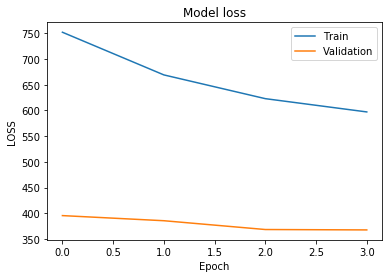

In [38]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [39]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [40]:
adam = Adam(learning_rate=tclr)
model.compile(loss='mse', optimizer=adam)

In [ ]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1, 
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/28
5613/5613 [==============================] - 901s 161ms/step - loss: 553.1205 - val_loss: 365.3135
Epoch 2/28
5613/5613 [==============================] - 901s 160ms/step - loss: 544.7419 - val_loss: 363.1245
Epoch 3/28
5613/5613 [==============================] - 901s 161ms/step - loss: 531.2322 - val_loss: 360.7960
Epoch 4/28
5613/5613 [==============================] - 900s 160ms/step - loss: 519.8090 - val_loss: 358.7242
Epoch 5/28
5613/5613 [==============================] - 900s 160ms/step - loss: 537.7463 - val_loss: 358.2088
Epoch 6/28
5613/5613 [==============================] - 900s 160ms/step - loss: 535.6622 - val_loss: 357.3051
Epoch 7/28
5613/5613 [==============================] - 901s 160ms/step - loss: 534.1042 - val_loss: 356.6457
Epoch 8/28
5613/5613 [==============================] - 900s 160ms/step - loss: 532.1493 - val_loss: 355.9770
Epoch 9/28
5613/5613 [==============================] - 901s 160ms/step - loss: 531.7778 - val_loss: 355.0615
Epoch 10/2

In [ ]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model ' + i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [ ]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [ ]:
adam = Adam(learning_rate=MIN_LR*0.1)
model.compile(loss='mse', optimizer=adam)

In [ ]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[2],
                    shuffle=True,
                    verbose=1, 
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

In [ ]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [ ]:
model.save(filepath=RESULTS_DIR+"FinalCheckpoint_"+MODEL_VERSION+".h5", overwrite=True)

# Validation

In [ ]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [ ]:
train_preds = model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                            batch_size=PREDICT_BATCH_SIZE, verbose=1)

valid_preds = model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                            batch_size=PREDICT_BATCH_SIZE, verbose=1)

public_preds = model.predict(public_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                             batch_size=PREDICT_BATCH_SIZE, verbose=1)

private_preds = model.predict(private_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                              batch_size=PREDICT_BATCH_SIZE, verbose=1)

print(train_preds.shape, valid_preds.shape, public_preds.shape, private_preds.shape)

In [ ]:
if SCALING:
    train_demand = MMS_Y.inverse_transform(train_preds)
    valid_demand = MMS_Y.inverse_transform(valid_preds)
    public_demand = MMS_Y.inverse_transform(public_preds)
    private_demand = MMS_Y.inverse_transform(private_preds)
    
    data['prediction'] = 0
    data[['prediction']].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds
    data[['prediction']].loc[data.day_id.isin(VALID_INDICES)] = valid_preds
    data[['prediction']].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds
    data[['prediction']].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds

    data['demand_Unscaled'] = MMS_Y.inverse_transform(data[['demand']])
    data[[col+'_Unscaled' for col in CONT_VARS]] = pd.DataFrame(MMS.inverse_transform(data[CONT_VARS]))

In [ ]:
data['pred_demand'] = 0

if SCALING:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_demand.flatten()
else:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds.flatten()

In [ ]:
for i in ['Train', 'Valid', 'Public', 'Private']:
    print(i)
    print('\t',{
        i+'_RMSE' : np.round(mean_squared_error(y_true = data['demand'].loc[data.set == i],
                                                y_pred = data['pred_demand'].loc[data.set == i]),
                             2) if i!='Private' else 'None',
        i+"_REAL_SUM" : np.round(data['demand'].loc[data.set != i].sum(), 2),
        i+"_PRED_SUM" : np.round(data['pred_demand'].loc[data.set != i].sum(), 2),
    })

In [ ]:
# Is the distribution same?
data[['demand','pred_demand','set']].groupby('set').describe()

## Submission

In [ ]:
submission = data.loc[data['set'].isin(['Private', 'Public'])][['id',
                                                                'day_id',
                                                                'pred_demand', 
                                                                'set']].copy().reset_index(drop=True)

In [ ]:
submission['day_id2'] = 'F' + pd.Series(np.where(submission['day_id']<=max(PUBLIC_INDICES), 
                                                 submission['day_id'] - min(PUBLIC_INDICES) + 1, 
                                                 submission['day_id'] - min(PRIVATE_INDICES) + 1).astype(int).astype(str))

In [ ]:
submission['id'] = np.where(submission['set']=="Public",
                            submission['id'].str.replace("evaluation", "validation"), 
                            submission['id'])

In [ ]:
submission.groupby('set').agg({
    'day_id':[np.min, np.max]
})

In [ ]:
submission_file = submission.pivot(
    values='pred_demand',
    index='id',
    columns='day_id2').reset_index(drop=False)
submission_file = submission_file[['id']+["F"+str(i) for i in range(1,29,1)]]

In [ ]:
submission_file.head()

In [ ]:
submission_file.tail()

In [ ]:
submission_file.to_csv('../results/submission_'+MODEL_VERSION+'.csv', index=False)

In [ ]:
end_time = time()
end = datetime.now()
print(ctime(end_time))
print(end - start, model_t - start, model_t - end)

#### Scaling is not working... Do it for the whole 2D array instead -- Now it is MinMax 0.1-0.9 Scaling -- No Scaling is Better it seems
#### Add weights during training... inside the fit call you need dynamic weighting -- Now both Train and Valid samples are weighted
#### Add More Features  -- More features have been added

## Add Conv1D -- Not done yet

## Make use of Dask instead of pandas